In [1]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import os
import sys
sys.path.append(os.path.abspath('../../src'))
import SortedNoDupeBedOverlap as bdO
import io_utils
import stats_utils

In [2]:
mat, id2bc, id2peak = io_utils.read_atac_count_10x('filtered_peak_bc_matrix', verbose = False)

In [3]:
ref_subtype_peaks0, ref_bk_peak = io_utils.read_reference_data('../../data/cistopic/', verbose = False)

In [4]:
intersect = set(bdO.BedOverlap(sorted(id2peak), sorted(ref_bk_peak), .5))

In [5]:
len(intersect)

66731

In [6]:
ref_subtype_peaks = []
for c, peaks in ref_subtype_peaks0:
    ref_subtype_peaks.append( (c, set(bdO.BedOverlap(sorted(id2peak), sorted(peaks), .5))) )

In [7]:
for c, peaks in ref_subtype_peaks:
    print(c, len(peaks))

Bcell 26394
CD34-Bone-Marrow 28109
CD34-Cord-Blood 26405
CD4Tcell 32960
CD8Tcell 36378
Mono 28887
NKcell 32530


In [8]:
mat.shape, len(id2peak)

((4654, 84626), 84626)

In [9]:
scores = stats_utils.compute_enrichment_score(mat, set(intersect), id2peak, ref_subtype_peaks, num_cores = 10)

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

mat = normalize(mat, norm='l1', axis=1)
svd = TruncatedSVD(n_components=20, n_iter=10, random_state=42)
pcas = svd.fit_transform(mat)

In [19]:
pcas.shape

(4654, 20)

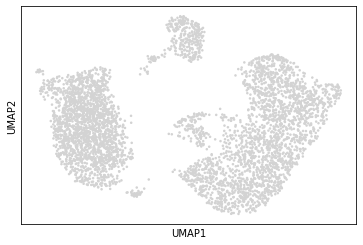

In [20]:
data_obj = sc.AnnData(pcas, 
          obs = pd.DataFrame([], index = id2bc),
          #var = pd.DataFrame([], index = id2peak),
          )

#sc.pp.normalize_total(data_obj)
#sc.pp.pca(data_obj, n_comps=50)
sc.pp.neighbors(data_obj, use_rep='X')
sc.tl.umap(data_obj)

sc.pl.umap(data_obj)

In [21]:
score_df = pd.DataFrame(scores, 
                        columns = [c for c, _ in ref_subtype_peaks],
                       index = data_obj.obs.index
                       )

In [22]:
len(scores)

4654

In [23]:
data_obj.obs = score_df

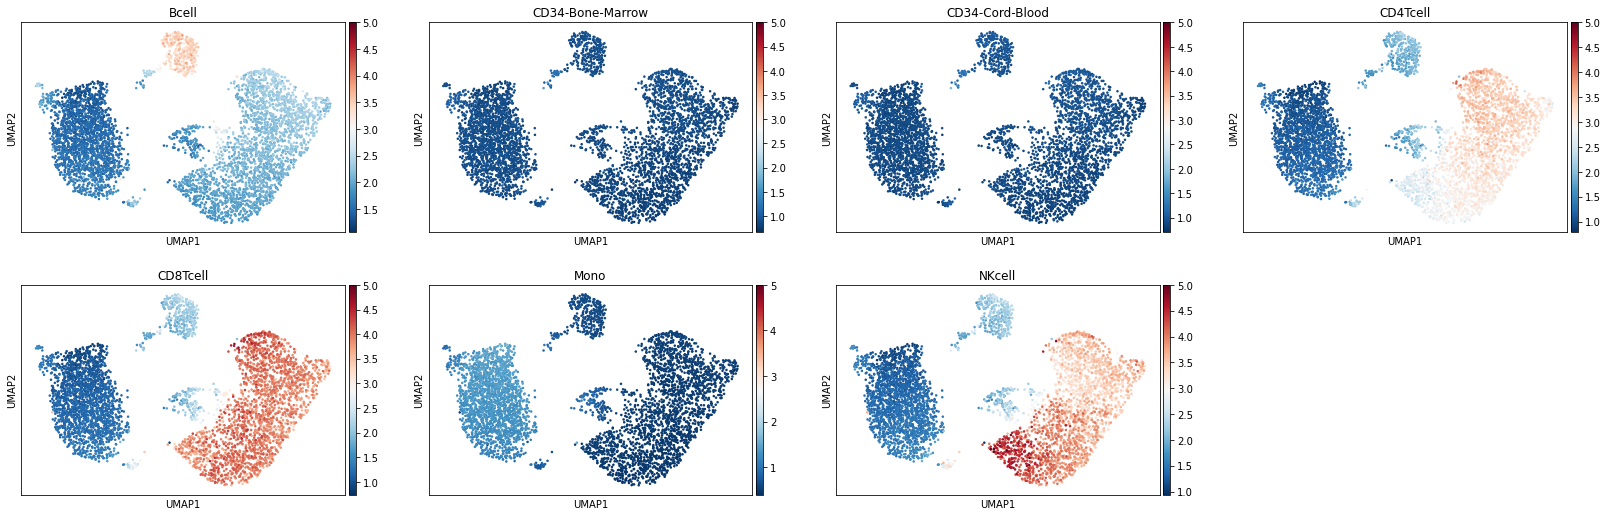

In [24]:
sc.pl.umap(data_obj, color = score_df.columns, cmap = 'RdBu_r', vmax = 5)

In [ ]:
pd.DataFrame(data_obj.obsm['X_umap'], index = data_obj.obs.index, columns = ['umap1', 'umap2']).to_csv('umap.csv')